In [8]:
pip install tensorflow scikit-learn


In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model


from keras.models import Sequential
from keras.layers import LSTM, Dense, Input
from keras.layers import Dropout



from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

In [56]:
df = pd.read_csv('C:/Users/DELL 7280/Downloads/FPT.csv')
df = df.drop(columns=["Ticker", "Open Interest"])
print(df)


              Date/Time   Open   High    Low  Close  Volume
0       12/25/2018 9:15  30.89  30.89  30.89  30.89   35410
1       12/25/2018 9:16  30.81  30.81  30.81  30.81     190
2       12/25/2018 9:17  30.74  30.81  30.74  30.74    1120
3       12/25/2018 9:18  30.74  30.74  30.74  30.74    2120
4       12/25/2018 9:19  30.74  30.74  30.74  30.74   22500
...                 ...    ...    ...    ...    ...     ...
97401  12/22/2020 14:24  58.20  58.20  58.20  58.20   27470
97402  12/22/2020 14:25  58.20  58.20  58.20  58.20   14820
97403  12/22/2020 14:26  58.20  58.20  58.20  58.20     500
97404  12/22/2020 14:29  58.10  58.10  58.10  58.10    2500
97405  12/22/2020 14:46  58.10  58.10  58.10  58.10   11170

[97406 rows x 6 columns]


In [21]:
df["Date/Time"] = pd.to_datetime(df["Date/Time"], format="%m/%d/%Y %H:%M")

In [22]:
df.shape

(97406, 6)

In [23]:
df.head()

,Date/Time,Open,High,Low,Close,Volume
0,2018-12-25 09:15:00,30.89,30.89,30.89,30.89,35410
1,2018-12-25 09:16:00,30.81,30.81,30.81,30.81,190
2,2018-12-25 09:17:00,30.74,30.81,30.74,30.74,1120
3,2018-12-25 09:18:00,30.74,30.74,30.74,30.74,2120
4,2018-12-25 09:19:00,30.74,30.74,30.74,30.74,22500


In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97406 entries, 0 to 97405
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date/Time  97406 non-null  datetime64[ns]
 1   Open       97406 non-null  float64       
 2   High       97406 non-null  float64       
 3   Low        97406 non-null  float64       
 4   Close      97406 non-null  float64       
 5   Volume     97406 non-null  int64         
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 4.5 MB


In [25]:
df.describe()

,Date/Time,Open,High,Low,Close,Volume
count,97406,97406.000000,97406.000000,97406.000000,97406.000000,9.740600e+04
mean,2020-01-21 05:08:51.739112192,45.071630,45.090138,45.051430,45.071631,8.044173e+03
min,2018-12-25 09:15:00,30.250000,30.250000,30.220000,30.250000,1.000000e+01
25%,2019-08-06 11:06:15,39.740000,39.740000,39.700000,39.740000,7.500000e+02
50%,2020-01-31 10:37:30,46.950000,46.950000,46.950000,46.950000,2.960000e+03
75%,2020-07-14 09:54:45,49.200000,49.250000,49.170000,49.200000,8.960000e+03
max,2020-12-22 14:46:00,58.400000,58.500000,58.400000,58.400000,1.255930e+06
std,NaN,6.359803,6.364950,6.354245,6.359799,1.753203e+04


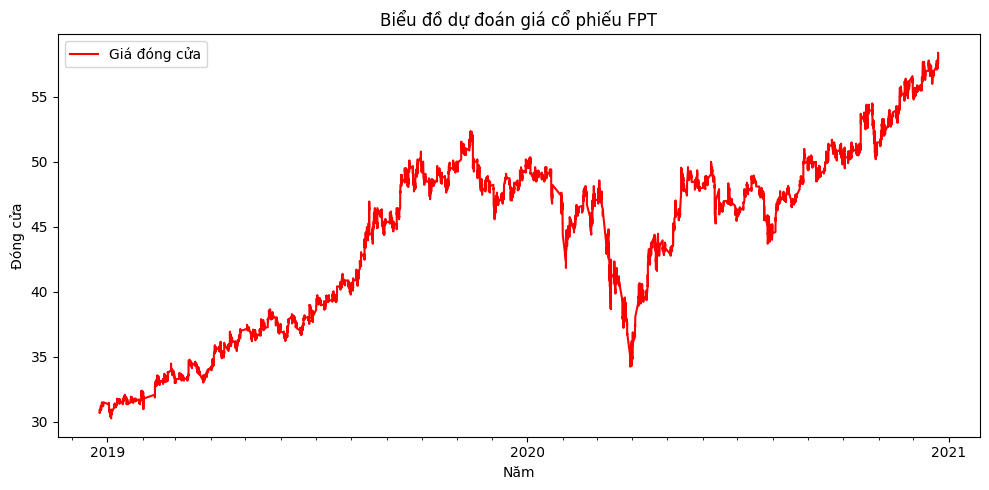

In [59]:
from matplotlib.dates import YearLocator, DateFormatter, MonthLocator


df['Date/Time'] = pd.to_datetime(df['Date/Time'], format='%m/%d/%Y %H:%M')


df = df.sort_values(by='Date/Time')




df['Năm'] = df['Date/Time'].dt.year


plt.figure(figsize=(10, 5))
plt.plot(df['Date/Time'], df['Close'], label='Giá đóng cửa', color='red')
plt.xlabel('Năm')
plt.ylabel('Đóng cửa')
plt.title('Biểu đồ dự đoán giá cổ phiếu FPT')
plt.legend(loc='best')


years = YearLocator()
yearsFmt = DateFormatter('%Y')
months = MonthLocator()
plt.gca().xaxis.set_major_locator(years)
plt.gca().xaxis.set_major_formatter(yearsFmt)
plt.gca().xaxis.set_minor_locator(months)

plt.tight_layout()
plt.show()

In [61]:
df1 = pd.DataFrame(df,columns=['Date/Time','Close'])
df1.index = df1['Date/Time']
df1.drop('Date/Time',axis=1,inplace=True)
df1

,Close
Date/Time,
2018-12-25 09:15:00,30.89
2018-12-25 09:16:00,30.81
2018-12-25 09:17:00,30.74
2018-12-25 09:18:00,30.74
2018-12-25 09:19:00,30.74
...,...
2020-12-22 14:24:00,58.20
2020-12-22 14:25:00,58.20
2020-12-22 14:26:00,58.20


In [29]:
data = df1.values
train_data = data[:1500]
test_data = data[1500:]

In [30]:
data

array([[30.89],
       [30.81],
       [30.74],
       ...,
       [58.2 ],
       [58.1 ],
       [58.1 ]])

In [31]:
sc = MinMaxScaler(feature_range=(0,1))
sc_train = sc.fit_transform(data)

In [32]:
x_train,y_train=[],[]
for i in range(50,len(train_data)):
  x_train.append(sc_train[i-50:i,0])
  y_train.append(sc_train[i,0])

In [33]:
x_train

[array([0.02273535, 0.01989343, 0.01740675, 0.01740675, 0.01740675,
        0.01740675, 0.01456483, 0.03055062, 0.03339254, 0.03339254,
        0.03197158, 0.03055062, 0.03055062, 0.03055062, 0.03339254,
        0.03339254, 0.03055062, 0.03445826, 0.03445826, 0.02806394,
        0.02806394, 0.02522202, 0.02522202, 0.02522202, 0.02522202,
        0.02273535, 0.02273535, 0.02522202, 0.02273535, 0.02273535,
        0.02522202, 0.02522202, 0.02806394, 0.03339254, 0.03055062,
        0.03197158, 0.03197158, 0.03055062, 0.03055062, 0.03055062,
        0.03055062, 0.03339254, 0.03339254, 0.03339254, 0.03055062,
        0.03055062, 0.03055062, 0.03055062, 0.03055062, 0.03197158]),
 array([0.01989343, 0.01740675, 0.01740675, 0.01740675, 0.01740675,
        0.01456483, 0.03055062, 0.03339254, 0.03339254, 0.03197158,
        0.03055062, 0.03055062, 0.03055062, 0.03339254, 0.03339254,
        0.03055062, 0.03445826, 0.03445826, 0.02806394, 0.02806394,
        0.02522202, 0.02522202, 0.02522202, 0.

In [34]:
y_train

[0.03197158081705154,
 0.030550621669626965,
 0.03197158081705154,
 0.030550621669626965,
 0.03197158081705154,
 0.030550621669626965,
 0.030550621669626965,
 0.030550621669626965,
 0.030550621669626965,
 0.030550621669626965,
 0.03197158081705154,
 0.03197158081705154,
 0.03197158081705154,
 0.030550621669626965,
 0.030550621669626965,
 0.030550621669626965,
 0.030550621669626965,
 0.030550621669626965,
 0.030550621669626965,
 0.029129662522202615,
 0.029129662522202615,
 0.029129662522202615,
 0.029129662522202615,
 0.029129662522202615,
 0.028063943161634075,
 0.029129662522202615,
 0.028063943161634075,
 0.029129662522202615,
 0.028063943161634075,
 0.030550621669626965,
 0.030550621669626965,
 0.030550621669626965,
 0.028063943161634075,
 0.028063943161634075,
 0.026642984014209725,
 0.028063943161634075,
 0.028063943161634075,
 0.025222024866785153,
 0.025222024866785153,
 0.025222024866785153,
 0.024156305506216835,
 0.025222024866785153,
 0.025222024866785153,
 0.02806394316163

In [35]:
x_train = np.array(x_train)
y_train = np.array(y_train)


x_train = np.reshape(x_train,(x_train.shape[0],x_train.shape[1],1))
y_train = np.reshape(y_train,(y_train.shape[0],1))

In [42]:

model = Sequential()

model.add(Input(shape=(x_train.shape[1], 1)))


model.add(LSTM(units=128, return_sequences=True))


model.add(LSTM(units=64))

# Dropout để ngăn overfitting
model.add(Dropout(0.5))

# Lớp Dense cuối cùng với đầu ra là 1 giá trị
model.add(Dense(1))

# Compile mô hình
model.compile(loss='mean_absolute_error', optimizer='adam')


In [43]:
save_model = "C:/Users/DELL 7280/Downloads/save_model.keras"
best_model = ModelCheckpoint(save_model,monitor='loss',verbose=2,save_best_only=True,mode='auto')
model.fit(x_train,y_train,epochs=100,batch_size=50,verbose=2,callbacks=[best_model])

Epoch 1/100

Epoch 1: loss improved from inf to 0.00946, saving model to C:/Users/DELL 7280/Downloads/save_model.keras
29/29 - 6s - 210ms/step - loss: 0.0095
Epoch 2/100

Epoch 2: loss improved from 0.00946 to 0.00518, saving model to C:/Users/DELL 7280/Downloads/save_model.keras
29/29 - 3s - 87ms/step - loss: 0.0052
Epoch 3/100

Epoch 3: loss improved from 0.00518 to 0.00418, saving model to C:/Users/DELL 7280/Downloads/save_model.keras
29/29 - 2s - 70ms/step - loss: 0.0042
Epoch 4/100

Epoch 4: loss improved from 0.00418 to 0.00375, saving model to C:/Users/DELL 7280/Downloads/save_model.keras
29/29 - 2s - 71ms/step - loss: 0.0037
Epoch 5/100

Epoch 5: loss improved from 0.00375 to 0.00323, saving model to C:/Users/DELL 7280/Downloads/save_model.keras
29/29 - 3s - 89ms/step - loss: 0.0032
Epoch 6/100

Epoch 6: loss improved from 0.00323 to 0.00311, saving model to C:/Users/DELL 7280/Downloads/save_model.keras
29/29 - 4s - 143ms/step - loss: 0.0031
Epoch 7/100

Epoch 7: loss did not i

In [44]:
y_train = sc.inverse_transform(y_train)
final_model = load_model("C:/Users/DELL 7280/Downloads/save_model.keras")
y_train_predict = final_model.predict(x_train)
y_train_predict = sc.inverse_transform(y_train_predict)

46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step


In [45]:
test = df1[len(train_data)-50:].values
test = test.reshape(-1,1)
sc_test = sc.transform(test)

x_test = []
for i in range(50,test.shape[0]):
  x_test.append(sc_test[i-50:i,0])
x_test = np.array(x_test)
x_test = np.reshape(x_test,(x_test.shape[0],x_test.shape[1],1))


y_test = data[1500:]
y_test_predict = final_model.predict(x_test)
y_test_predict = sc.inverse_transform(y_test_predict)

2998/2998 ━━━━━━━━━━━━━━━━━━━━ 95s 32ms/step


C:\Users\DELL 7280\AppData\Local\Temp\ipykernel_11908\347224890.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data1['Dự đoán'] = y_train_predict
C:\Users\DELL 7280\AppData\Local\Temp\ipykernel_11908\347224890.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data1['Dự đoán'] = y_test_predict


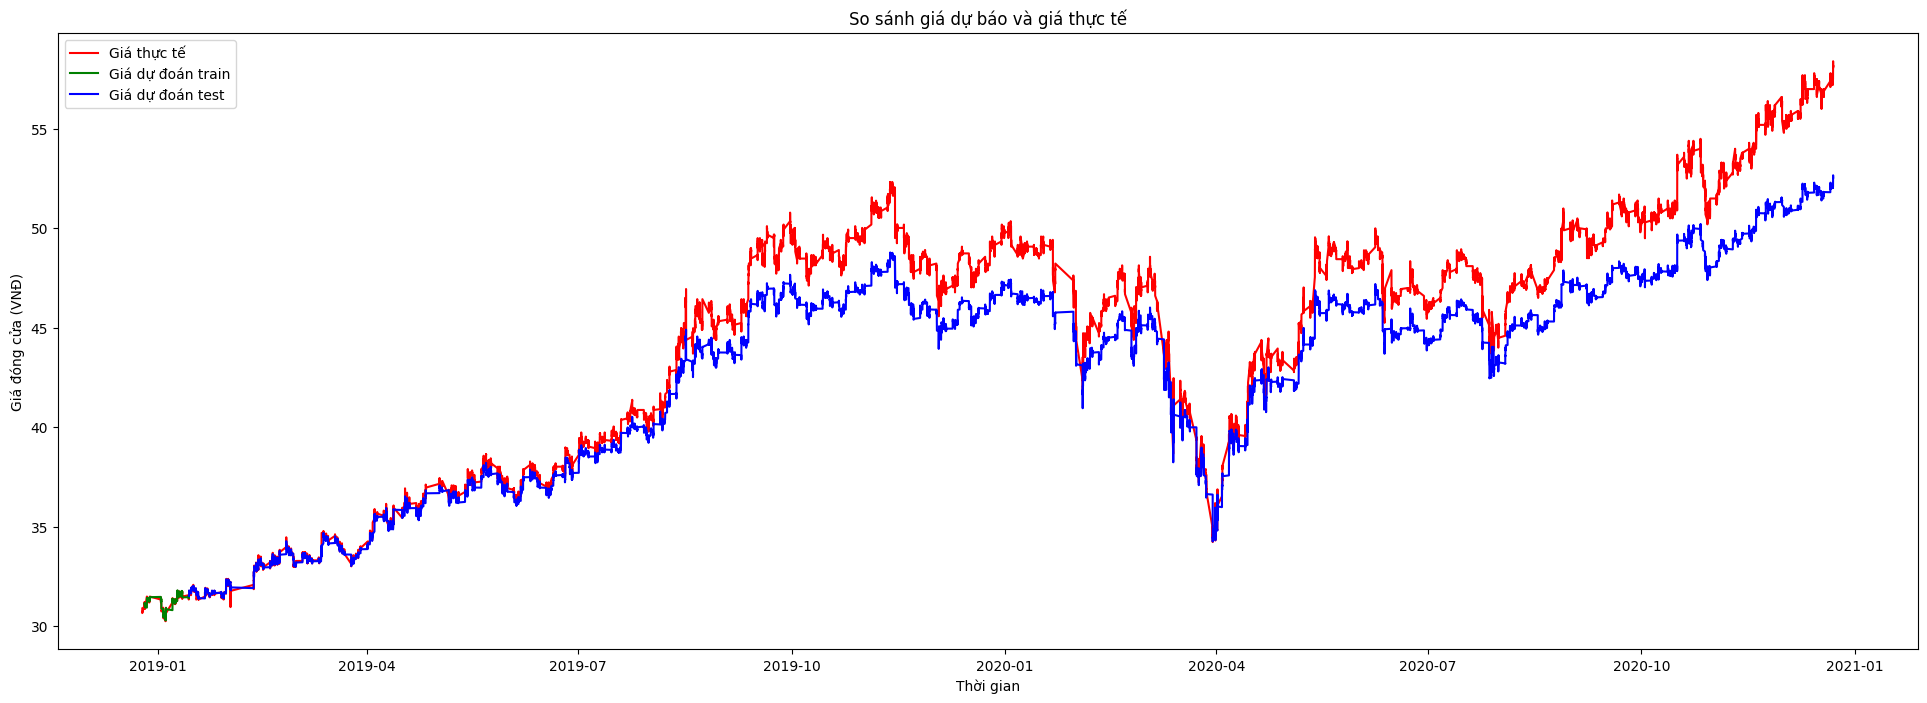

In [46]:
train_data1 = df1[50:1500]
test_data1 = df1[1500:]

plt.figure(figsize=(24,8))
plt.plot(df1,label='Giá thực tế',color='red')
train_data1['Dự đoán'] = y_train_predict
plt.plot(train_data1['Dự đoán'],label='Giá dự đoán train',color='green')
test_data1['Dự đoán'] = y_test_predict
plt.plot(test_data1['Dự đoán'],label='Giá dự đoán test',color='blue')
plt.title('So sánh giá dự báo và giá thực tế')
plt.xlabel('Thời gian')
plt.ylabel('Giá đóng cửa (VNĐ)')
plt.legend()
plt.show()

In [47]:
#r2
print('Độ phù hợp tập train:',r2_score(y_train,y_train_predict))
#mae
print('Sai số tuyệt đối trung bình trên tập train (VNĐ):',mean_absolute_error(y_train,y_train_predict))
#mae
print('Phần trăm sai số tuyệt đối trung bình tập train:',mean_absolute_percentage_error(y_train,y_train_predict))

Độ phù hợp tập train: 0.9785706425776365
Sai số tuyệt đối trung bình trên tập train (VNĐ): 0.0428749414378204
Phần trăm sai số tuyệt đối trung bình tập train: 0.0013762345978422129


In [48]:
train_data1

,Close,Dự đoán
Date/Time,,
2018-12-26 10:19:00,31.15,31.152515
2018-12-26 10:20:00,31.11,31.162903
2018-12-26 10:21:00,31.15,31.160915
2018-12-26 10:22:00,31.11,31.165567
2018-12-26 10:23:00,31.15,31.160835
...,...,...
2019-01-14 10:57:00,31.49,31.488138
2019-01-14 11:00:00,31.49,31.493191
2019-01-14 11:04:00,31.49,31.501556


In [49]:
#r2
print('Độ phù hợp tập test:',r2_score(y_test,y_test_predict))
#mae
print('Sai số tuyệt đối trung bình trên tập test (VNĐ):',mean_absolute_error(y_test,y_test_predict))
#mae
print('Phần trăm sai số tuyệt đối trung bình tập test:',mean_absolute_percentage_error(y_test,y_test_predict))

Độ phù hợp tập test: 0.8655037117619762
Sai số tuyệt đối trung bình trên tập test (VNĐ): 1.869859000973201
Phần trăm sai số tuyệt đối trung bình tập test: 0.038185494908032344


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


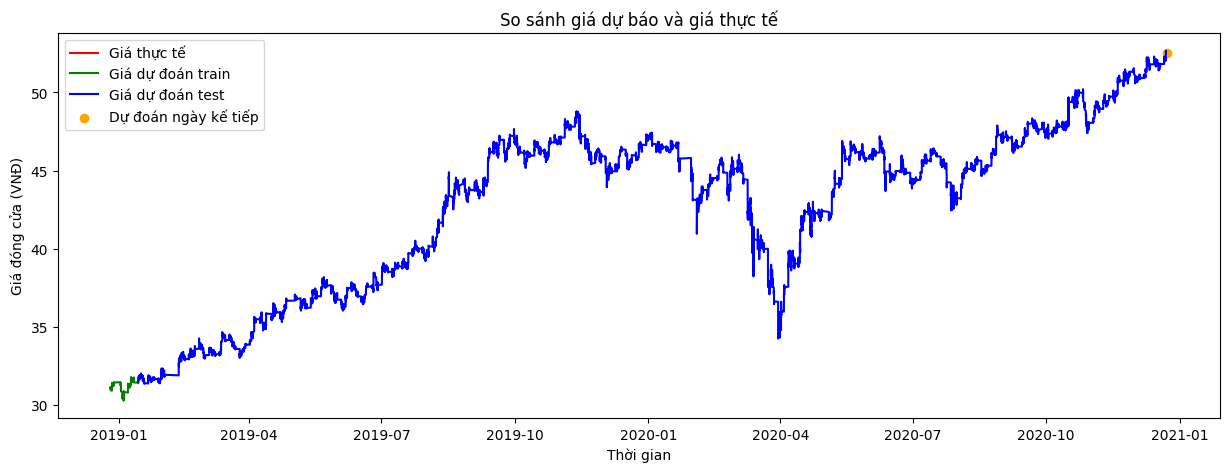

In [53]:
df['Date/Time'] = pd.to_datetime(df['Date/Time'])
next_date = df['Date/Time'].iloc[-1] + pd.Timedelta(days=1)


next_date = pd.to_datetime(next_date)


next_closing_price = np.array([df['Close'].iloc[-1]])


next_closing_price_normalized = sc.transform(next_closing_price.reshape(-1, 1))


x_next = np.array([sc_train[-50:, 0]])
x_next = np.reshape(x_next, (x_next.shape[0], x_next.shape[1], 1))
y_next_predict = final_model.predict(x_next)
y_next_predict = sc.inverse_transform(y_next_predict)


df_next = pd.DataFrame({'Date/Time': [next_date], 'Close': [y_next_predict[0][0]]})
df1 = pd.concat([df1, df_next])


plt.figure(figsize=(15, 5))
plt.plot(df1['Date/Time'], df1['Close'], label='Giá thực tế', color='red')
plt.plot(train_data1.index, train_data1['Dự đoán'], label='Giá dự đoán train', color='green')
plt.plot(test_data1.index, test_data1['Dự đoán'], label='Giá dự đoán test', color='blue')
plt.scatter([next_date], [y_next_predict[0][0]], color='orange', label='Dự đoán ngày kế tiếp')
plt.xlabel('Thời gian')
plt.ylabel('Giá đóng cửa (VNĐ)')
plt.title('So sánh giá dự báo và giá thực tế')
plt.legend()
plt.show()

In [54]:
actual_closing_price = df['Close'].iloc[-1]


comparison_df = pd.DataFrame({'date': [next_date], 'Giá dự đoán': [y_next_predict[0][0]], 'Giá ngày trước': [actual_closing_price]})


print(comparison_df)

                 date  Giá dự đoán  Giá ngày trước
0 2020-12-23 14:46:00    52.536369            58.1
